Part 1: EDA

In [1]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn import metrics
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold, train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score
from scipy import stats
 
 
from statsmodels.stats.outliers_influence import variance_inflation_factor

import warnings
warnings.filterwarnings("ignore")


Load & Merge datasets

In [2]:
#Load train dataset
df = pd.read_csv("C:/Users/Gia Uyen/Downloads/transaction.csv")

In [3]:
X = df.drop(['isFraud', 'TransactionID'], axis=1)
y = df['isFraud']

In [4]:
# using the train test split function
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.20, shuffle=True)

In [5]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((472432, 53), (472432,), (118108, 53), (118108,))

In [6]:
train = pd.concat([X_train, y_train], axis=1)
train.head()

,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,...,M1,M2,M3,M4,M5,M6,M7,M8,M9,isFraud
309472,7691153,1679.95,W,10616,583.0,150.0,visa,226.0,credit,387.0,...,NaN,NaN,NaN,NaN,NaN,T,NaN,NaN,NaN,0
422188,10693464,54.50,W,2581,445.0,150.0,mastercard,166.0,debit,325.0,...,T,T,T,M0,T,T,F,F,T,0
393062,9855314,117.00,W,13960,206.0,150.0,visa,166.0,debit,181.0,...,T,T,T,M0,F,F,F,F,F,0
62618,1435111,50.00,S,1682,409.0,150.0,visa,226.0,debit,204.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
309933,7697939,73.00,W,11554,310.0,150.0,mastercard,224.0,debit,204.0,...,T,T,T,M0,F,T,F,F,F,0


In [7]:
#create a dataframe to store the missing values in train set, with 3 columns: feature, missing_count, missing percentage
def missing_values_table(df):
    # Count the number of missing values in each column
    missing_count = df.isnull().sum()
    
    # Calculate the percentage of missing values
    missing_percentage = 100 * missing_count / len(df)
    
    # Create a DataFrame to store the results
    missing_values_df = pd.DataFrame({
        'Feature': missing_count.index,
        'Missing Count': missing_count.values,
        'Missing Percentage': missing_percentage.values
    })
    
    # Filter out columns with no missing values
    missing_values_df = missing_values_df[missing_values_df['Missing Count'] > 0]
    
    # Sort the DataFrame by the percentage of missing values in descending order
    missing_values_df = missing_values_df.sort_values(by='Missing Percentage', ascending=False).reset_index(drop=True)
    
    return missing_values_df

In [8]:
missing_df = missing_values_table(train)
with pd.option_context('display.max_rows', None,):
    print(missing_df.sort_values(by='Missing Count', ascending=True))


          Feature  Missing Count  Missing Percentage
34             D1           1011            0.213999
33          card3           1255            0.265647
32          card6           1259            0.266493
31          card4           1267            0.268187
30          card5           3401            0.719892
29          card2           7166            1.516832
28          addr2          52533           11.119696
27          addr1          52533           11.119696
26            D10          60887           12.887992
25            D15          71397           15.112651
24  P_emaildomain          75489           15.978808
23             D4         135153           28.607927
22             M6         135532           28.688150
21             D3         210499           44.556465
18             M2         217009           45.934441
20             M1         217009           45.934441
19             M3         217009           45.934441
17            D11         223579           47.

EDA

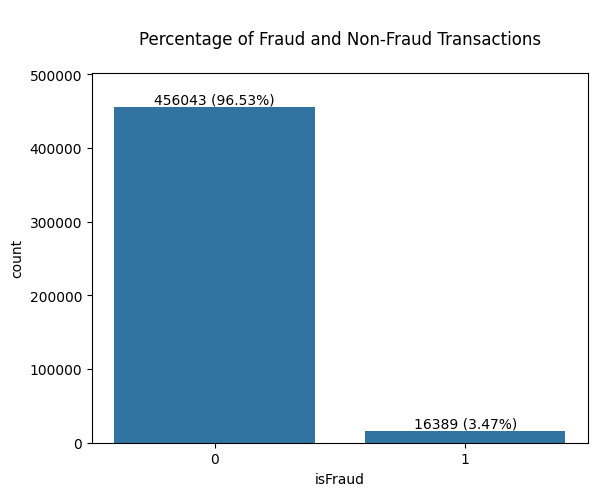

In [9]:
#find percentage of fraud transactions in train set
ax = sns.countplot(x='isFraud', data = train)

plt.title("\nPercentage of Fraud and Non-Fraud Transactions\n")

plt.margins(0.05, 0.1)

for p in ax.patches:
  x=p.get_bbox().get_points()[:,0]
  y=p.get_bbox().get_points()[1,1]
  ax.annotate('{} ({:.2f}%)'.format(int(y),100.*y/len(X_train)), (x.mean(), y), 
          ha='center', va='bottom') 

plt.xlabel('isFraud')
plt.show()

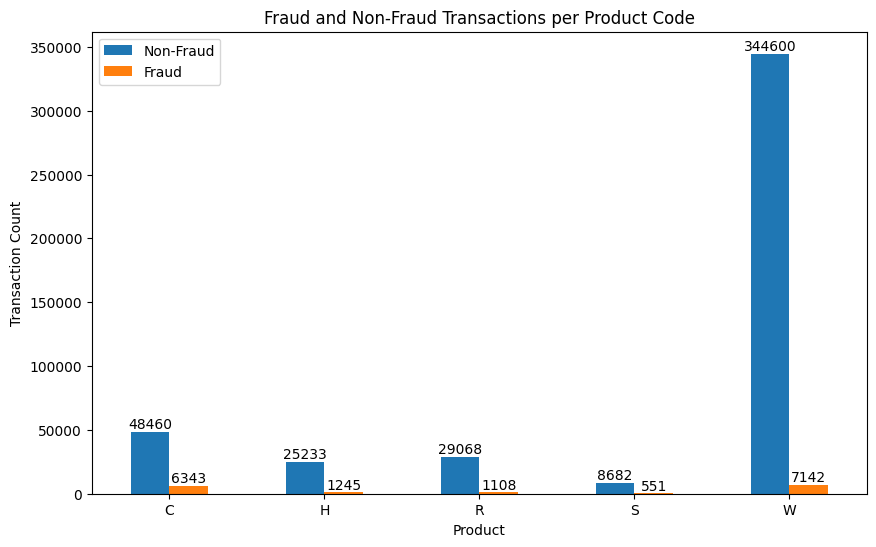

In [10]:
# Group by Product and Is_Fraud and count the occurrences
grouped_df = train.groupby(['ProductCD', 'isFraud']).size().unstack(fill_value=0)

# Plotting
ax = grouped_df.plot(kind='bar', stacked=False, figsize=(10, 6))

# Adding title and labels
plt.title('Fraud and Non-Fraud Transactions per Product Code')
plt.xlabel('Product')
plt.ylabel('Transaction Count')
plt.xticks(rotation=0)
plt.legend(['Non-Fraud', 'Fraud'])

# Annotate bars with the data values
for p in ax.containers:
    ax.bar_label(p, label_type='edge')
               
# Show plot
plt.show()

It seems like produce code 'C' is most likely to have the highest number of fraud transactions.

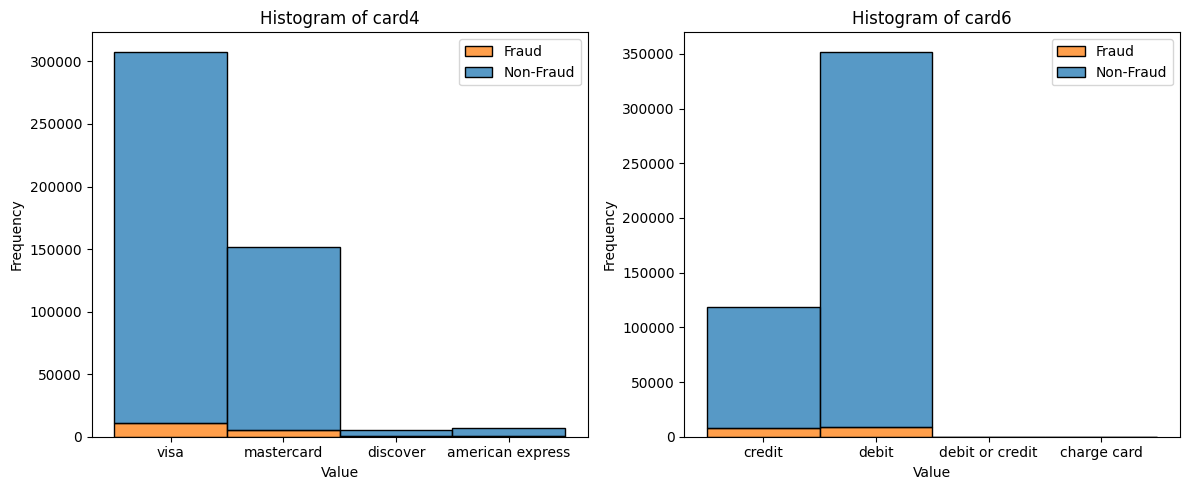

In [11]:
# Create a figure with two subplots, arranged side by side
plt.figure(figsize=(12, 5))

# First subplot for Column1
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
sns.histplot(data=train, x='card4', hue='isFraud', multiple='stack', discrete=True)
plt.title('Histogram of card4')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend(['Fraud', 'Non-Fraud'])

# Second subplot for Column2
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
sns.histplot(data=train, x='card6', hue='isFraud', multiple='stack', discrete=True)
plt.title('Histogram of card6')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend(['Fraud', 'Non-Fraud'])

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

Most of Card holders used debit card from mastercard and visa to purchase the transactions. Credit cards have a higher percentage of fraud transactions.

TransactionDT

In [12]:
train[['TransactionDT']].describe().astype(int)

,TransactionDT
count,472432
mean,7370638
std,4618110
min,86400
25%,3024863
50%,7303629
75%,11246522
max,15811131


In [13]:
Transaction_date = (train[['TransactionDT']]/86400)
print(Transaction_date.describe())

       TransactionDT
count  472432.000000
mean       85.308321
std        53.450352
min         1.000000
25%        35.009997
50%        84.532743
75%       130.168087
max       182.999201


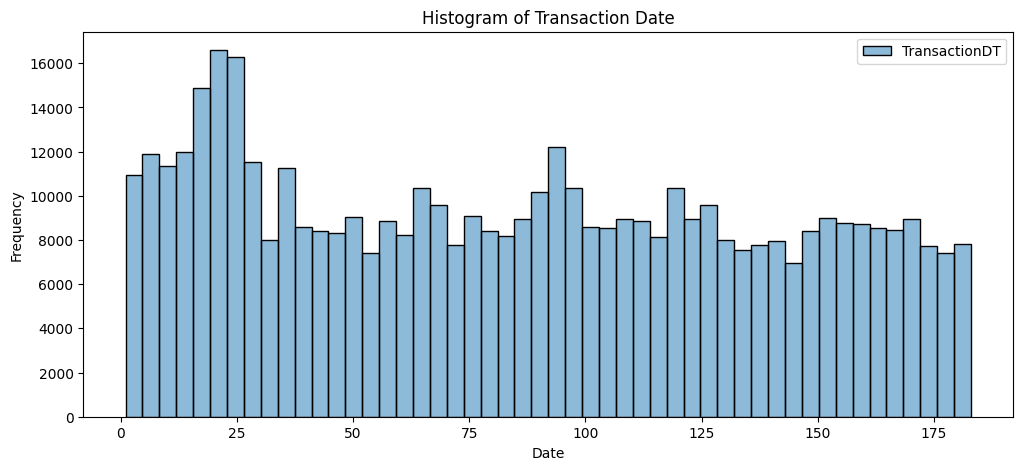

In [14]:
# create a histogram of the transaction date
plt.figure(figsize=(12, 5))
sns.histplot(Transaction_date,bins=50, kde=False)
plt.title('Histogram of Transaction Date')
plt.xlabel('Date')
plt.ylabel('Frequency')
plt.show()

TransactionAmt

In [15]:
#find descriptive statistics of TransactionAmt 
NonFraud_Transaction_Amount = train[train['isFraud'] == 0]['TransactionAmt'].describe()
Fraud_Transaction_Amount = train[train['isFraud'] == 1]['TransactionAmt'].describe()

#combine NonFraud_Transaction_Amount,Fraud_Transaction_Amount into one dataframe
pd.DataFrame({'Non-Fraud': NonFraud_Transaction_Amount,'Fraud': Fraud_Transaction_Amount})

,Non-Fraud,Fraud
count,456043.000000,16389.000000
mean,134.510227,148.910289
std,237.089146,232.031176
min,0.251000,0.292000
25%,43.970000,35.346000
50%,68.500000,75.000000
75%,119.950000,161.000000
max,31937.391000,5191.000000


Fraud transactions have a higher mean of Transaction Amount compared to Non-Fraud transactions.

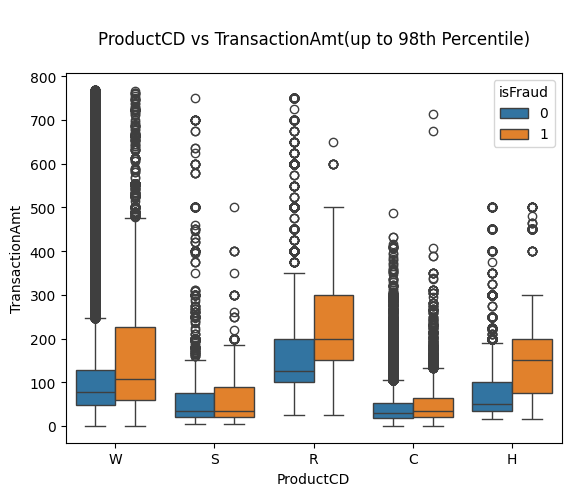

In [16]:
sns.boxplot(x='ProductCD', y='TransactionAmt', data= train[train['TransactionAmt']<=np.percentile(train['TransactionAmt'], 98)], hue='isFraud')
plt.title('\nProductCD vs TransactionAmt(up to 98th Percentile)\n')
plt.show()

Comments:
This dataset has 569877 non-fraud transactions (96.5% of the dataset) and 20663 fraud transactions (3.5% of the dataset). This dataset is highly imbalanced with many features having a large number of missing values

Data Cleaning

In [17]:
#Removing columns with more than 70% missing values
high_missing_value_cols_train = [col for col in train.columns if train[col].isna().sum()/len(train) > 0.7]
 
#Removing columns with same values for all its rows
same_value_cols_train = [col for col in train.columns if train[col].nunique()<=1]
 
#Removing columns with more than 80% of the values are the same
constant_value_cols_train = [col for col in train.columns if train[col].value_counts(dropna=False, normalize=True).values[0] > 0.8]


In [18]:
#drop these columns from train set
drop_cols = list(set(high_missing_value_cols_train + same_value_cols_train + constant_value_cols_train))

if 'isFraud' in drop_cols:
  drop_cols.remove('isFraud')

train.drop(drop_cols, axis=1, inplace=True)

Removing Collinear Features

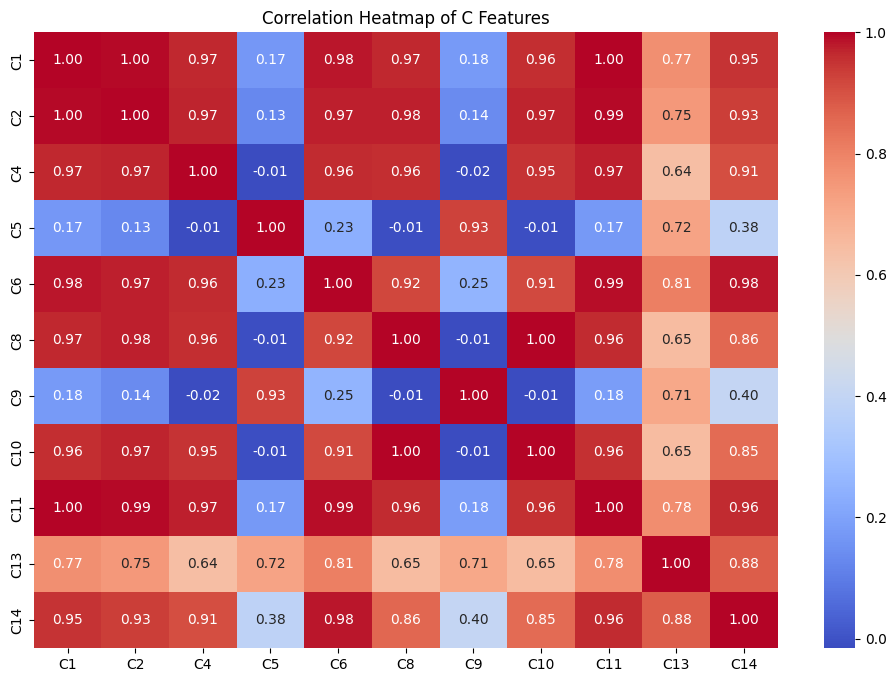

In [19]:
#C_features
C_features = ["C"+str(i) for i in range(1,15) if "C"+str(i) in train.columns]

#create correlation heatmap of C_features
plt.figure(figsize=(12, 8))
sns.heatmap(train[C_features].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of C Features')
plt.show()

In [20]:
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = C_features

# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(train[C_features].values, i)
                          for i in range(len(C_features))] 

print(vif_data)

   feature          VIF
0       C1   495.599003
1       C2   288.027637
2       C4   537.900413
3       C5    14.972524
4       C6   523.570711
5       C8   814.219088
6       C9    65.308303
7      C10   424.261375
8      C11  1656.776806
9      C13    39.335116
10     C14   339.677215


In [21]:
#drop C-features with VIF larger than 100
train.drop(['C1','C2','C4','C6','C8','C10','C11','C14'], axis=1, inplace=True)

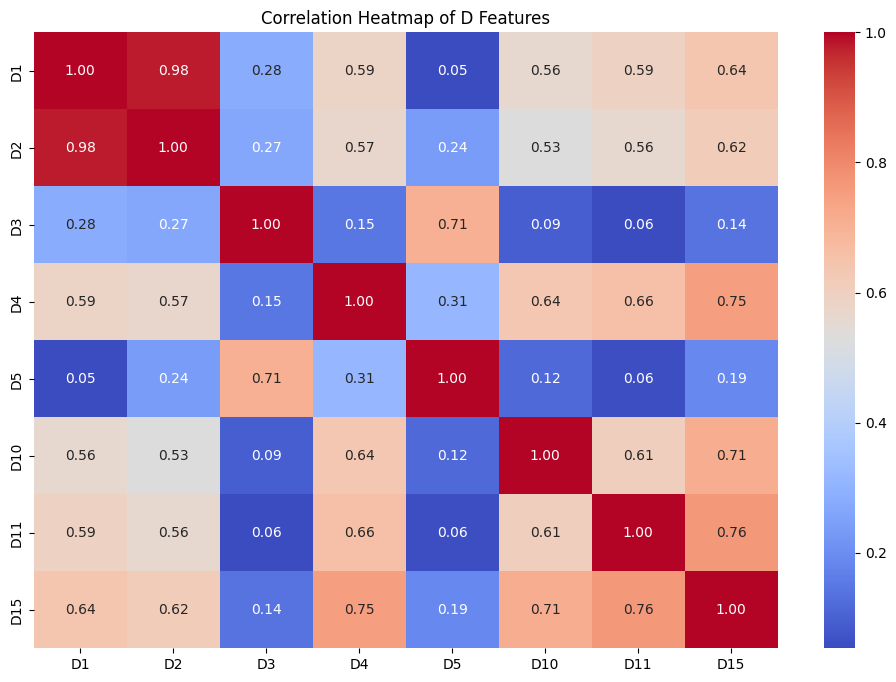

In [22]:
#D_features
D_features = ["D"+str(i) for i in range(1,16) if "D"+str(i) in train.columns]

#create correlation heatmap of D_features
plt.figure(figsize=(12, 8))
sns.heatmap(train[D_features].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of D Features')
plt.show()

### Feature Engineering

Transaction Hour

In [23]:
train['Trans_Hour'] = (train['TransactionDT']//3600)%24

In [24]:
normalized_trans_hr = (train.groupby(['isFraud'])['Trans_Hour'].value_counts(normalize=True).rename('percentage').mul(100).reset_index().sort_values('isFraud'))

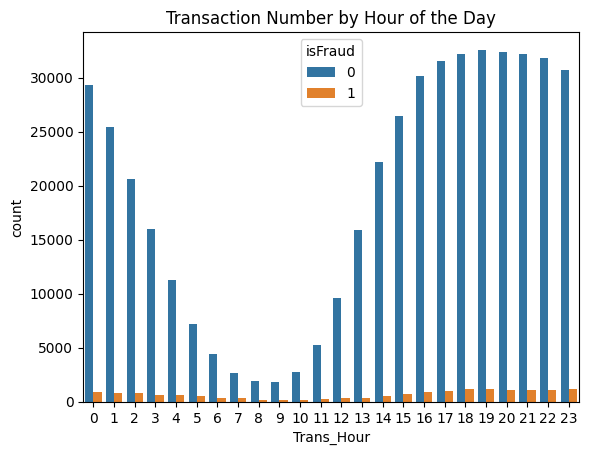

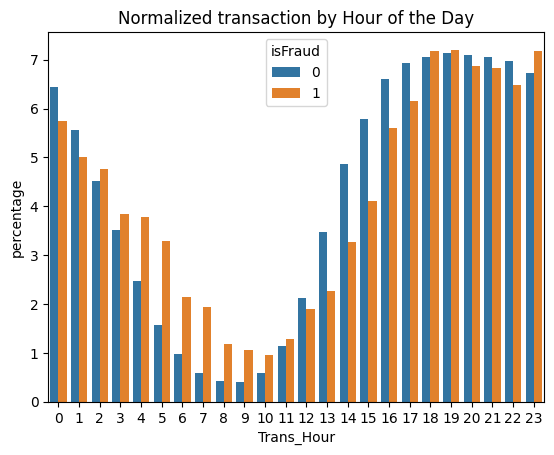

In [25]:
sns.countplot(x='Trans_Hour', hue='isFraud', data=train)
plt.title("Transaction Number by Hour of the Day")
plt.show()
sns.barplot(x="Trans_Hour", y="percentage", hue="isFraud", data=normalized_trans_hr)
plt.title("Normalized transaction by Hour of the Day")
plt.show()

From the above plot, we can see that when the number of legit transactions in an hour is smaller, then the percentage of fraud transactions in that hour is larger.

Transaction Day

In [26]:
train['Trans_Day'] = train['TransactionDT']//(24*3600)

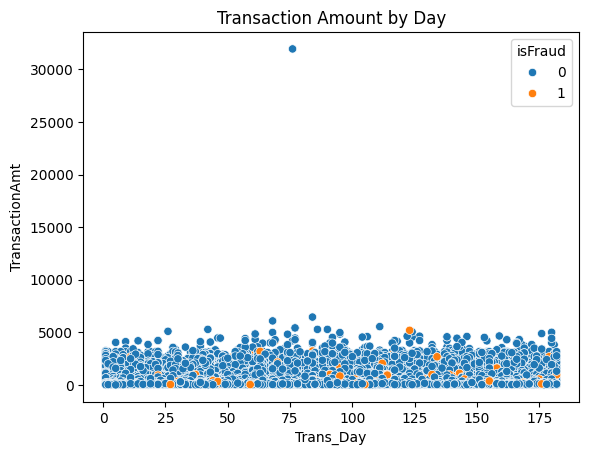

In [27]:
sns.scatterplot(y='TransactionAmt', x='Trans_Day', hue='isFraud', data=train)
plt.title("Transaction Amount by Day")
plt.show()

There are outliers in the train data with transaction amount over 30000, which I will need to remove from the dataset

Part 2: Train base XGBoost model

In [31]:
#find all categorical & numerical columns in train set
cat_columns = X_train.select_dtypes(include=['object']).columns
#find all numerical columns in train set
num_columns = [col for col in X_train.columns if col not in cat_columns and not col == 'isFraud']

In [32]:
#imputing missing values with "na"
X_train[cat_columns] = X_train[cat_columns].fillna('missing')

#label encoding for categorical columns
for col in cat_columns:
    X_train[col] = X_train[col].astype(str)
    label_encoder = LabelEncoder()
    label_encoder.fit(X_train[col])
    X_train[col] = label_encoder.transform(X_train[col])

In [53]:
#find all categorical & numerical columns in train set
cat_columns_test = X_test.select_dtypes(include=['object']).columns
#find all numerical columns in train set
num_columns_test = [col for col in X_test.columns if col not in cat_columns_test and not col == 'isFraud']

#imputing missing values with "na"
X_test[cat_columns_test] = X_test[cat_columns_test].fillna('missing')

#label encoding for categorical columns
for col in cat_columns_test:
    X_test[col] = X_test[col].astype(str)
    label_encoder = LabelEncoder()
    label_encoder.fit(X_test[col])
    X_test[col] = label_encoder.transform(X_test[col])

Hyperparameter Tuning

In [33]:
#Fit the algorithm on the data
xgb1 = XGBClassifier(
    learning_rate =0.3,
    n_estimators=1000,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'binary:logistic',
    nthread=4,
    scale_pos_weight=1,
    eval_metric='auc',
    seed=27)
 
xgb1.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, n_jobs=None, nthread=4,
              num_parallel_tree=None, ...)

In [34]:
#Predict training set:
predictions = xgb1.predict(X_train)
pred_prob = xgb1.predict_proba(X_train)[:,1]

#Print model report:
print("\nModel Report")
print("Accuracy : %.4g" % metrics.accuracy_score(y_train.values, predictions))
print("AUC Score (Train): %f" % metrics.roc_auc_score(y_train, pred_prob)) 


Model Report
Accuracy : 0.9938
AUC Score (Train): 0.996289


In [37]:
param_test1 = {
    'max_depth':range(8, 12, 16),
    'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=200, max_depth=5, min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8, objective = 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), param_grid = param_test1, scoring='roc_auc',n_jobs=4,  cv=5)
gsearch1.fit(X_train,y_train)

gsearch1.best_params_, gsearch1.best_score_

({'max_depth': 8, 'min_child_weight': 1}, 0.9655207927604461)

The ideal values are 8 for max_depth and 1 for min_child_weight. 

In [38]:
param_test2 = {'gamma':[i/10.0 for i in range(0,5)]}
gsearch2 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, 
                                                  n_estimators=200, 
                                                  max_depth=8, 
                                                  min_child_weight=1, 
                                                  gamma=0, 
                                                  subsample=0.8, 
                                                  colsample_bytree=0.8, 
                                                  objective = 'binary:logistic', 
                                                  nthread=4, 
                                                  scale_pos_weight=1, 
                                                  seed=27), 
                        param_grid = param_test2, 
                        scoring='roc_auc',
                        n_jobs=4,  
                        cv=5)

gsearch2.fit(X_train,y_train)

gsearch2.best_params_, gsearch2.best_score_

({'gamma': 0.2}, 0.9531136067342547)

The optimal values for gamma is 0.2

In [39]:
param_test3 = { 'subsample':[i/10.0 for i in range(6,10)],
               'colsample_bytree':[i/10.0 for i in range(6,10)]}
gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, 
                                                  n_estimators=200, 
                                                  max_depth=8, 
                                                  min_child_weight=1, 
                                                  gamma=0.2, 
                                                  subsample=0.8, 
                                                  colsample_bytree=0.8, 
                                                  objective = 'binary:logistic', 
                                                  nthread=4, 
                                                  scale_pos_weight=1, 
                                                  seed=27), 
                        param_grid = param_test3, 
                        scoring='roc_auc',
                        n_jobs=4,  
                        cv=5)

gsearch3.fit(X_train,y_train)

gsearch3.best_params_, gsearch3.best_score_

({'colsample_bytree': 0.8, 'subsample': 0.8}, 0.9531136067342547)

The optimal values for subsample is 0.8 and for colsample_bytree is 0.8

In [41]:
#Fit the algorithm on the data after hyperparameter tuning
xgb2 = XGBClassifier(
    learning_rate =0.1,
    n_estimators= 1000,
    max_depth=8,
    min_child_weight=1,
    gamma=0.2,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'binary:logistic',
    nthread=4,
    scale_pos_weight=1,
    eval_metric='auc',
    seed=27)
 
xgb2.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=0.2, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, n_jobs=None, nthread=4,
              num_parallel_tree=None, ...)

In [42]:
#Predict training set:
predictions2 = xgb2.predict(X_train)
pred_prob2 = xgb2.predict_proba(X_train)[:,1]

#Print model report:
print("\nModel Report")
print("Accuracy : %.4g" % metrics.accuracy_score(y_train.values, predictions2))
print("AUC Score (Train): %f" % metrics.roc_auc_score(y_train, pred_prob2)) 


Model Report
Accuracy : 0.9974
AUC Score (Train): 0.999602


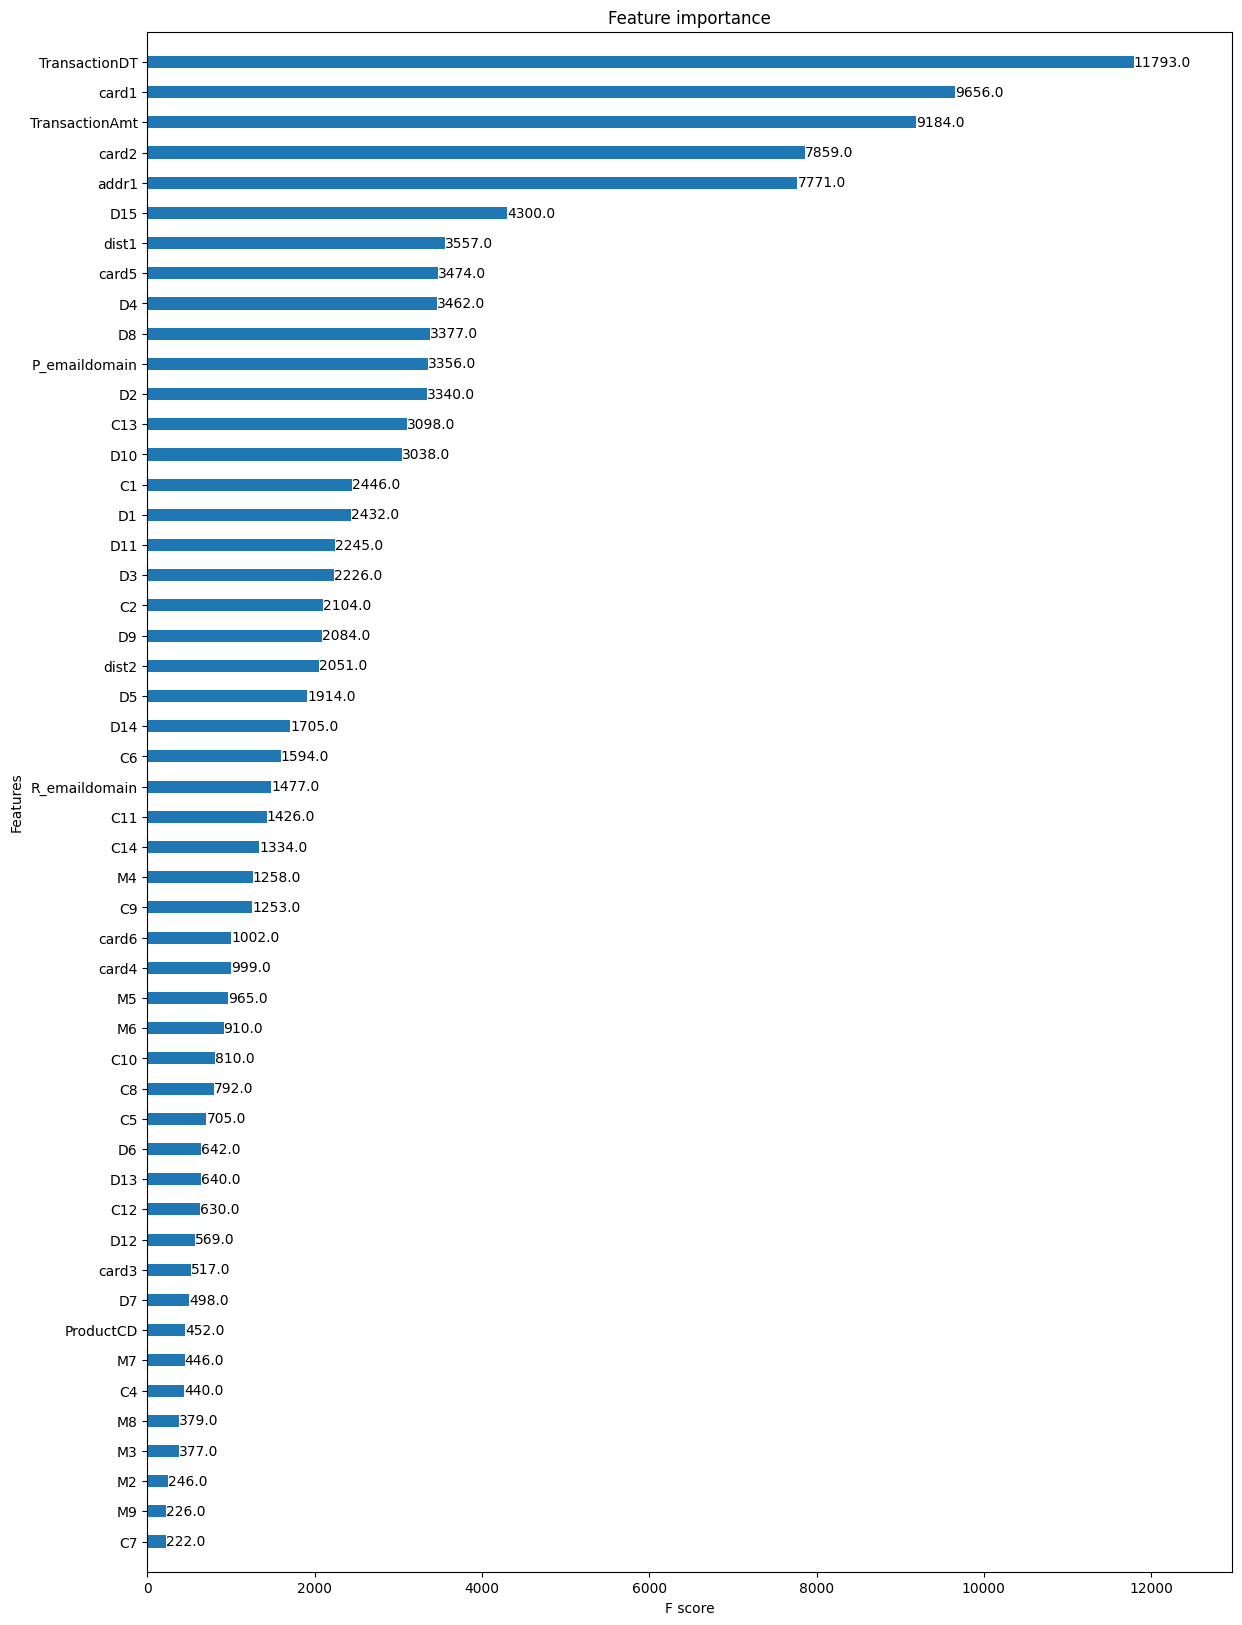

In [43]:
plt.rcParams["figure.figsize"] = (14, 20)
xgb.plot_importance(xgb2,max_num_features=50, grid=False, height=0.4)
plt.show()

In [44]:
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.20, shuffle=False)

In [45]:
train_proba = xgb2.predict_proba(X_train)[:,1]
cv_proba = xgb2.predict_proba(X_cv)[:,1]

In [46]:
train_fpr, train_tpr, train_threshold = metrics.roc_curve(y_train, train_proba)
train_roc_auc = metrics.auc(train_fpr, train_tpr)

In [47]:
cv_fpr, cv_tpr, cv_threshold = metrics.roc_curve(y_cv, cv_proba)
cv_roc_auc = metrics.auc(cv_fpr, cv_tpr)

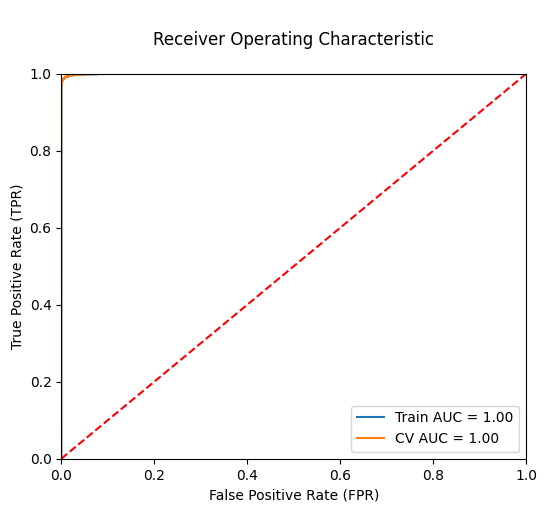

In [48]:
plt.rcParams["figure.figsize"] = (6, 5)
plt.title('\nReceiver Operating Characteristic\n')
plt.plot(train_fpr, train_tpr, label = 'Train AUC = %0.2f' % train_roc_auc)
plt.plot(cv_fpr, cv_tpr, label = 'CV AUC = %0.2f' % cv_roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate (TPR)')
plt.xlabel('False Positive Rate (FPR)')
plt.show()


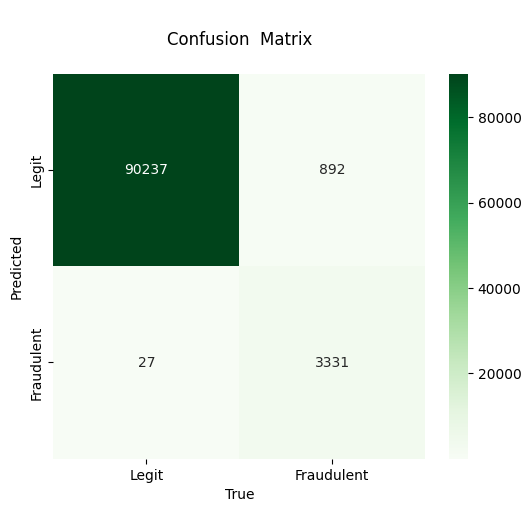

In [49]:
best_threshold = cv_threshold[np.argmax(cv_tpr*(1-cv_fpr))]  
cv_pred = np.where(cv_proba > best_threshold,1,0)

cv_cm = confusion_matrix(y_cv, cv_pred)
sns.heatmap(cv_cm, annot=True,fmt="d",cmap='Greens', xticklabels=['Legit', 'Fraudulent'], yticklabels=['Legit', 'Fraudulent'])
plt.title('\nConfusion  Matrix\n')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.show() 


Final Model on Test Set

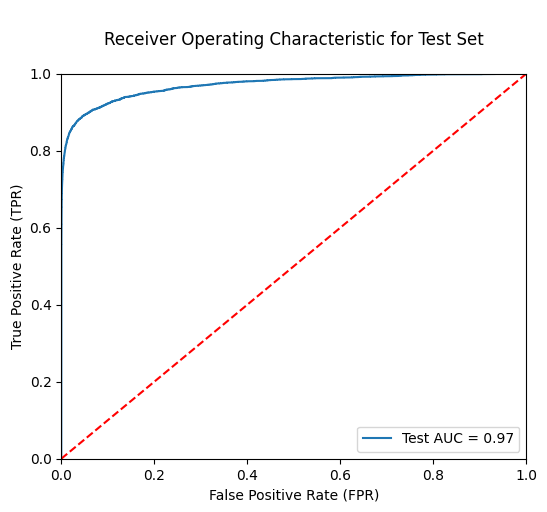

In [54]:
test_proba = xgb2.predict_proba(X_test)[:,1]

test_fpr, test_tpr, test_threshold = metrics.roc_curve(y_test, test_proba)
test_roc_auc = metrics.auc(test_fpr, test_tpr)

plt.rcParams["figure.figsize"] = (6, 5)
plt.title('\nReceiver Operating Characteristic for Test Set\n')
plt.plot(test_fpr, test_tpr, label = 'Test AUC = %0.2f' % test_roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate (TPR)')
plt.xlabel('False Positive Rate (FPR)')
plt.show()

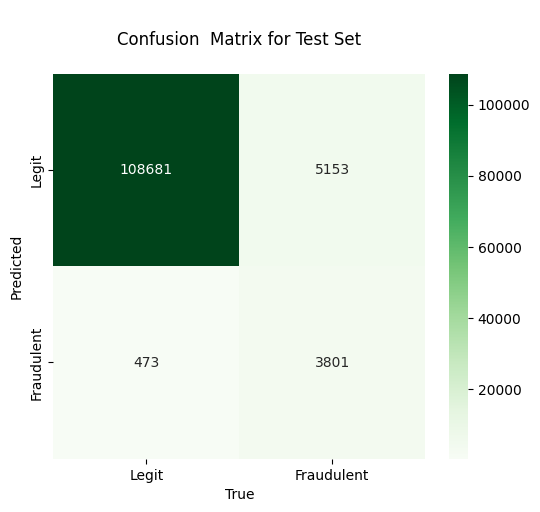

In [56]:
best_threshold_test = test_threshold[np.argmax(test_tpr*(1-test_fpr))]  
test_pred = np.where(test_proba > best_threshold_test,1,0)

test_cm = confusion_matrix(y_test, test_pred)
sns.heatmap(test_cm, annot=True,fmt="d",cmap='Greens', xticklabels=['Legit', 'Fraudulent'], yticklabels=['Legit', 'Fraudulent'])
plt.title('\nConfusion  Matrix for Test Set\n')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.show()